# DSCI 512 Lecture 6



In [1]:
import numpy as np
import networkx as nx
import scipy.sparse
import urllib.request

In [2]:
# The defaults are hard to see on a projector in class
draw_params = {"node_color" : "pink", "font_size" : 20, "with_labels" : True, "arrowsize" : 30}

Outline:

- Graph representations: adjacency matrices, adjacency lists (10 min)
- Sparse matrices (30 min)
- Break (5 min)
- Python generators (15 min)
- Python `map` and `reduce` (20 min)

No time for: 

- T/F questions (25 min)

## Graph representations (5 min)

In [3]:
G = nx.bull_graph()

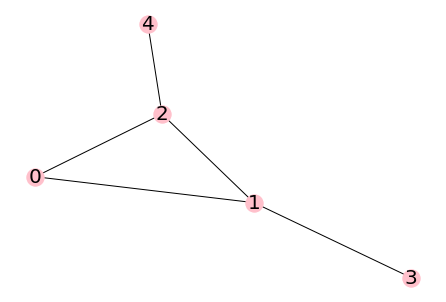

In [5]:
nx.draw(G, **draw_params)

We can represent the graph as an _adjacency list_. It lists all pairs of vertices that are connected, for example $(0,1)$.

In [6]:
print(G.edges())

[(0, 1), (0, 2), (1, 2), (1, 3), (2, 4)]


Or, we can represent the graph as an _adjacency matrix_. 

In [7]:
adj = nx.adjacency_matrix(G).toarray()
adj

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

In [10]:
adj.T

array([[0, 1, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

In [9]:
G.nodes

NodeView((0, 1, 2, 3, 4))

- This matrix has size `# vertices` x `# vertices`
- This representation is often nice. For example we can check if any two nodes $i$ and $j$ are connected in $O(1)$ time:

In [8]:
adj[1, 3]

1

What is the space complexity of these two representations? Let $E$ be the number of edges and $V$ be the number of vertices. Then

- Adjacency list: $O(E)$
- Adjacency matrix: $O(V^2)$

Question: Which is better?

<br><br><br><br><br><br><br><br>

- Answer: the adjacency list seems better. 
- In the worst case of a complete graph, then $E=O(V^2)$ and the two are about the same. 
- But if $E=V$, say, then the matrix seems very wasteful.

Wouldn't it be great if we could have the conceptual interface of the adjacency matrix, with the storage requirements of an adjacency list? Enter sparse matrices.

## Sparse matrices (20 min)

In [11]:
G = nx.ladder_graph(5)

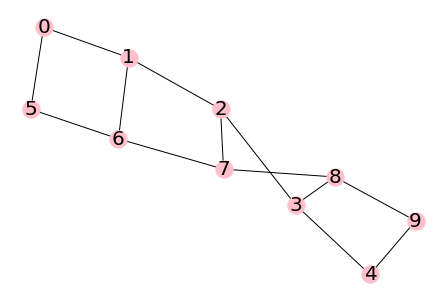

In [12]:
nx.draw(G, **draw_params)

In [13]:
am_ladder = nx.adjacency_matrix(G)

In [14]:
type(am_ladder)

scipy.sparse.csr.csr_matrix

- Sparse matrices are conceptual data structure like a list, dictionary, set, etc.
- [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html) matrices are the Python implementation of this conceptual data structure, like `list`, `dict`, `set`, etc.
- Going to that link, we can see there are many types of scipy sparse matrix.
  - This one is a [`csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)
  - More later on these types.
- You can convert them to numpy arrays with `toarray()`, but this is usually a bad idea.

In [15]:
print(am_ladder.toarray())

[[0 1 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 1 0 0]
 [0 0 1 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 1 0]]


In [57]:
type(am_ladder.toarray())

numpy.ndarray

In [58]:
type(am_ladder)

scipy.sparse.csr.csr_matrix

In [16]:
# make a bigger graph with more vertices/edges
G = nx.fast_gnp_random_graph(100_000, 1e-4)

In [17]:
len(G.nodes)

100000

In [18]:
am = nx.adjacency_matrix(G)

In [19]:
am.shape

(100000, 100000)

In [20]:
am.nnz

997126

Stored in full form, the matrix would take up:

In [21]:
full_size = np.prod(am.shape)*8/1e9
print("The full matrix would take up %d GB" % full_size)

The full matrix would take up 80 GB


That's a lot! How big is the sparse matrix?

In [22]:
sparse_size = am.data.nbytes/1e6
print("The sparse matrix takes up %d MB" % sparse_size)

The sparse matrix takes up 7 MB


So, the fraction of space saved is:

In [23]:
frac_nz = am.nnz / np.prod(am.shape)
print("The sparse matrix is %dx smaller" % (1/frac_nz))

The sparse matrix is 10028x smaller


- Right, so we definitely don't want to store the full matrix.
- Let's do some operations on the sparse matrix.

Get all neighbours of vertex $i$:

In [24]:
i = 0
print(am[i])

  (0, 2212)	1
  (0, 24594)	1
  (0, 25312)	1
  (0, 30034)	1
  (0, 33722)	1
  (0, 39097)	1
  (0, 42939)	1
  (0, 44581)	1
  (0, 45964)	1
  (0, 50999)	1
  (0, 73787)	1


- There are some weird things to know about scipy sparse matrices.
- For example, with a regular numpy array, `x[i,j]` and `x[i][j]` are equivalent:

In [27]:
x = np.random.rand(10, 10)

In [28]:
x[1, 2]

0.3191168444204733

In [29]:
x[1][2]

0.3191168444204733

In [30]:
(x[1])[2]

0.3191168444204733

This is because `x[1]` returns the first row, and then the `[2]` indexes into that row:

In [31]:
x[1]

array([0.46777805, 0.73525205, 0.31911684, 0.13398204, 0.50020097,
       0.02357571, 0.95440155, 0.48169332, 0.66582331, 0.91017439])

In [32]:
row_1 = x[1]
row_1[2]

0.3191168444204733

However, with `scipy.sparse` matrices, things are a bit different:

In [33]:
x_sparse = scipy.sparse.csr_matrix(x)

In [34]:
x_sparse[1, 2]

array(0.31911684)

In [35]:
x_sparse[1][2]

IndexError: row index (2) out of range

Why?

In [36]:
row_1_sparse = x_sparse[1]

In [37]:
row_1_sparse.shape

(1, 10)

- The sparse matrix returns a different shape, leaving in the first dimension.
- This can be annoying and is something to watch out for.
- In general, I suggest using the `x[1,2]` notation when possible because chaining the `[]` can be problematic in several places (e.g., also pandas).
- However, this is only for numpy, not, say, a list of lists:

In [39]:
lst = [[1, 2, 3], [4, 5, 6], [7, 9]]
lst

[[1, 2, 3], [4, 5, 6], [7, 9]]

In [40]:
lst[0][1]

2

In [41]:
lst[0, 1]

TypeError: list indices must be integers or slices, not tuple

#### sparse matrix operations

Let's try to find the vertex with the most neighbours:

In [44]:
x = np.random.randint(10, size=(4,5))
x

array([[2, 8, 4, 3, 5],
       [3, 6, 5, 4, 8],
       [2, 2, 0, 6, 9],
       [3, 8, 4, 5, 6]])

In [45]:
np.sum(x)

93

In [47]:
np.sum(x, axis=0)

array([10, 24, 13, 18, 28])

In [48]:
np.sum(x, axis=1)

array([22, 26, 19, 26])

Back to the adjacency matrix:

In [56]:
am.getnnz(axis=1)

array([11,  9, 14, ...,  7, 10, 11], dtype=int32)

In [51]:
ind = np.argmax(am.getnnz(axis=1))
val = np.max(am.getnnz(axis=1))

print("Vertex", ind, "has", val, "neighbours")

Vertex 37280 has 25 neighbours


- Regular numpy functions work on sparse matrices, although they might be fast/slow depending. 
- You definitely do not want to iterate through the rows - make sure you use builtin numpy functions. 

In [52]:
num_rows, num_cols = am.shape

In [53]:
%%timeit -r1 -n1 

# iterate through the rows - this is much slower than numpy functions
for i in range(num_rows):
    am[i, :]

8.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
# %%timeit -r1 -n1

# # iterate through the columns - this is much MUCH slower
# for i in range(num_cols):
#     am[:, i]

Commenting it out because it's so slow. Here's a screenshot of the output:

![](slowcode.png)

Above: 

- Looping is slower, as per usual.
- But at least looping through the rows of a `csr_matrix` isn't that bad.
- However, looping through the columns of a `csr_matrix` is a disaster - it took 13 min on my laptop!!
  - Because it is stored _row by row_. 
  - To grab a single column, it needs to loop through each row and look for items in that column.
- Let's say you really needed a loop (usually not the case!) - then you would first convert the matrix type.

In [54]:
am_csc = am.tocsc()

In [55]:
%%timeit -r1 -n1

for i in range(num_cols):
    am_csc[:, i]

8.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Note: adjacency matrices are symmetric, so looping through the rows or the columns makes no difference.
- However you often (usually!) have non-symmetric matrices, in which case this issue could definitely come up.
- But again, use built-in numpy functions whenever you can!!

#### sparse data sets

Sparse matrices come up _a lot_ in practice, beyond just adjacency matrices in graphs. For example:

- Word counts: we might represent a document by which words are in it, but only a small fraction of all words would appear in a given document.
- Ratings: we might represent an Amazon item by the user ratings, but only a small fraction of all users have rated a given item.
- Physical processes: in a 2019 Capstone project, students examined images from a particle physics dataset, in which most of the sensors got zero signal.
- etc.

#### nearest neighbours with sparse matrices

- In Lecture 4 we discussed nearest neighbour algorithms.
- We need to think carefully about the idea of _distance_ when dealing with sparse vectors.
  - Euclidean distance doesn't necessarily make sense.
  - It may depend if we have sparse vectors of sparse _binary_ vectors (like in the adjacency matrix).
  - Both are common in practice.
  - For sparse binary vectors, the distance could just be the number of places they differ.
  - E.g. dist$((0,0,1), (0,1,1))=1$ because they differ in one place (the second entry).
- Different nearest neighbour algorithms might need to be used for sparse vectors.
- E.g. $k$-d trees don't really make sense because "dividing the space in half" doesn't really do anything interesting; they are already divided.

## Break (5 min)

## Python generators (10 min)

**Note:** this next part is not related to graphs; it is a standalone small topic in the course.

- Imagine you have access to a _stream_ of data, which you can process one bit at a time.
- Imagine the overall data set is too large to fit into memory (space complexity!).
- Is there a way to process one piece of data at a time in Python?

Example: you want to know what fraction of English words start with a vowel. 

In [59]:
words = urllib.request.urlopen(
    "https://github.com/dwyl/english-words/raw/master/words.txt")

- In this case, we could actually load all the words, but imagine a bigger data set (this happens a lot)
- In that case, `words.read()` would crash
- Luckily, there is `words.readline()`

In [60]:
for i in range(10):
    w = words.readline().decode("utf-8").strip().lower()
    print(w)

2
1080
&c
10-point
10th
11-point
12-point
16-point
18-point
1st


In [61]:
vowels = ('a', 'e', 'i', 'o', 'u')

In [62]:
words = urllib.request.urlopen(
    "https://github.com/dwyl/english-words/raw/master/words.txt")

totalWords = 1000000
vowelWords = 0

for i in range(totalWords):
    w = words.readline().decode("utf-8").strip().lower()
    if len(w) > 0 and w[0] in vowels:
        vowelWords += 1

In [63]:
vowelWords/totalWords

0.101738

- I skipped some details here, like how to know when the stream is finished (it should return `None`)
- The question is, how would you write something like this yourself?
- Example: you want to return the sequence $1, \frac12, \frac13, \frac14, ...$

In [64]:
def numbers(n):
    nums = list()
    for i in range(1, n):
        nums.append(1/i)
    return nums

numbers(10)

[1.0,
 0.5,
 0.3333333333333333,
 0.25,
 0.2,
 0.16666666666666666,
 0.14285714285714285,
 0.125,
 0.1111111111111111]

Ok, this works, but what if we want a trillion numbers in the sequence, we are going to run out of memory.

In [94]:
def numbers_generator(n):
    for i in range(1, n):
        yield 1/i  # this is what makes it a generator
    

In [95]:
nums = numbers_generator(4)
nums

<generator object numbers_generator at 0xa2fdc4570>

In [96]:
result = next(nums)
result

1.0

In [97]:
next(nums)

0.5

- The generator is a function that "remembers where it was" when you last called it.
- It "yields" the data one at a time.
- This is essentially what `readline` is doing - getting the next word.
- `next` is a Python keyword that works for all generators.

You can also use generators in for loops, very conveniently:

In [99]:
total = 0
for num in numbers_generator(10):
    total += num
print(total)

2.8289682539682537


- That is, the `for` loop automatically calls `next`, so _iterating through a generator looks exactly like iterating through a list_.
- That is the key beauty of it; the rest of the code doesn't even care if you have a generator or a list, they are "interchangeable".
- This is great, because we can write code with `for` loops and not worry if the data is streaming in or not.

#### Generator comprehensions

- Remember in DSCI 511 that a comprehension with parentheses wasn't a tuple comprehension?
- This is actually a generator:

In [100]:
nums_list = [1/i for i in range(1,10)]
nums_list

[1.0,
 0.5,
 0.3333333333333333,
 0.25,
 0.2,
 0.16666666666666666,
 0.14285714285714285,
 0.125,
 0.1111111111111111]

In [101]:
nums_gen = (1/i for i in range(1,10))
nums_gen

<generator object <genexpr> at 0xa2fdc4660>

In [105]:
# range(np.inf)

Potentially confusing behaviour:

In [19]:
nums_gen = (1/i for i in range(1,5))

In [20]:
list(nums_gen)

[1.0, 0.5, 0.3333333333333333, 0.25]

In [21]:
list(nums_gen)

[]

- What happened? The generator got "used up" when it was converted to a list. It needs to be re-created to be used again.
- The code below can be run repeatdly because it re-makes the generator every time.

In [24]:
nums_gen = (1/i for i in range(1,5))
list(nums_gen)

[1.0, 0.5, 0.3333333333333333, 0.25]

## Python `map` and `reduce` (15 min)

- You may have heard about [MapReduce](https://en.wikipedia.org/wiki/MapReduce) in the context of big data.
- We won't get into details here, but at least we will introduce `map` and `reduce`.
- You also saw these in DSCI 511 (the R part), we'll go into slightly more detail and do it in Python.

#### `map`

In [3]:
def times_two(x):
    return x*2

data = [1, 2, 3, 4]

In [4]:
list(map(times_two, data))

[2, 4, 6, 8]

In [5]:
list(range(5))

[0, 1, 2, 3, 4]

- In more recent versions of Python, `map` returns a map object which is essentially a generator.
- The idea is that you might not want to store the results in memory, you probably just want to iterate through them.

In [6]:
result = map(times_two, data)

In [7]:
result[2]

TypeError: 'map' object is not subscriptable

In [8]:
next(result)

2

In [9]:
next(result)

4

You can explicitly cast the result to a list: 

In [10]:
list(map(times_two, data))

[2, 4, 6, 8]

In [11]:
[e for e in map(times_two, data)]

[2, 4, 6, 8]

But often this is unnecessary and just takes up more time/memory for no reason.

- You will see something similar to `map` going by many names, like `apply` in pandas. In R there is also `purrr:map`. 
- All of these have the same idea: apply a function to each element of a list.
- Or in fact it doesn't even have to be a list, it could be a generator:

In [128]:
result = map(times_two, map(times_two, data))

In [129]:
result

In [130]:
next(result)

4

Here, we applied `map` to a map object. This is already an example of the interchangeable nature of lists and generators. 

Note: you'll often see people using `lambda` functions inline, as in:

In [131]:
list(map(lambda x: x*2, data))

[2, 4, 6, 8]

This is more convenient than actually naming a function `times_two`, which feels unecessary.

#### `reduce`

In [132]:
from functools import reduce

- Another common operation is to reduce, or aggregate, data.
- Examples: sum, max

In [133]:
data

[1, 2, 3, 4]

In [134]:
sum(data)

10

In [135]:
max(data)

4

- These are examples of a general phenomenon in which data are aggregated **pairwise**. 
- That is, $1+2+3+4=((1+2)+3)+4$
- And $\max\{1,2,3,4\}=\max\{\max\{\max\{1,2\},3\},4\}$

In [136]:
reduce(lambda x, y: x+y, data)

10

In [137]:
reduce(lambda x, y: x if x > y else y, data)

4

Conveniently, `reduce` can take in a generator as the data, so it can be coupled effectively with `map`. For example:

In [138]:
reduce(lambda x, y: x+y, map(lambda x: x*2, data))

20

Here, we multiplied all the numbers by $2$ and then added them together. The generator from `map` was aggregated by `reduce`.

`reduce` and recursion:

- We tend to think of these functions recursively, especially `reduce`. 
- In fact, here is an implementation of `reduce`:

In [139]:
def my_reduce(func, data):
    """ 
    Apply a function to pairs of elements in data, recursively from left to right.

    Parameters
    ----------
    func : function
        a function taking two arguments, that we will reduce on
    data : list
        a list of values

    Returns
    -------
    object 
        in the interim this will return smaller lists, but the final result will be one object

    Example
    --------
    >>> data = [1,2,3,4]
    >>> my_reduce(lambda x,y: x*y, data)
    24
    """

    if len(data) == 1:
        return data[0]

    # Apply the function to the first two elements
    new_element = func(data[0], data[1])

    # Concatenate the new element and the rest of the list
    new_list = [new_element] + data[2:]

    # Recursively reduce on the new list
    return my_reduce(func, new_list)

In [140]:
my_reduce(lambda x, y: x+y, data)

10

- The ideas of data aggregation and recursion are tied together.
- You just need to define an aggregration operation on two elements, then apply recursively. 

Summary:

| Python name | Other names | Inputs      |  Outputs |
|-------------|-------------|-------------|----------|
|   `map`     |   apply     | a function of one argument and a list/iterable | a new list/iterable with the function applied to each element |
| `reduce`    | aggregate  | a function of two arguments and a list/iterable | a single value with the function applied recursively to pairs of elements |


## T/F questions (25 min)

1. For a graph with $E$ edges, the adjacency matrix is an $E\times E$ matrix.
2. Adjacency matrices of graphs are always symmetric. 
3. Adjacency matrices of graphs are always sparse.
4. The space complexity of storing an $n \times n$ sparse matrix is $O(n^2)$.

<br><br><br><br><br><br><br><br>

1. Python generators contain one or more `yield` statements instead of `return` statements.
2. Python generators allow "random access", i.e. `gen[3]` to get the 4th element.
3. `map(f, x)` applies the function `f` to every element of `x`.
4. It's is reasonable to use the same function `f` with both `map` and `reduce`.